# COMPORTAMENTO GEOGRÁFICO DA COVID-19 EM DIFERENTES CLASSES DE MUNICÍPIOS SEGUNDO HIERARQUIA URBANA, CONCENTRAÇÃO POPULACIONAL, CONCENTRAÇÃO DE RIQUEZA E NÍVEIS DE INTEGRAÇÃO E MOBILIDADE

## PREPARAÇÃO DO NOTEBOOK

* Importação das principais bibliotecas
* Configuração das operações por default (estilos e tamanhos de gráficos)
* Referenciamento das subpastas do projeto

In [1]:
# importação de bibliotecas básicas

import pandas as pd # Biblioteca para operação avançada com dados tabulares de diversos tipos
import numpy as np # Biblioteca para operação com vetores de auto desempenho e um tipo por vez
from matplotlib import use as mpl_use # Função Matplotlib que estabelece backend e precisa ser chamda antes do plt
mpl_use('nbagg') # uso do backend "nbagg" para os gráficos terem paineis interativos
import matplotlib.pyplot as plt # Biblioteca para geração de gráficos de menor nível de abstração
import seaborn as sns # Biblioteca baseada em matplotlib para geração de gráficos e estilização, com maior nível de abstração
import geopandas as gpd # Biblioteca de análise geográfica
import descartes # Dependência do Geopandas para poder gerar mapas
import matplotlib 
import os

In [2]:
# configurações das operações por default

# Configuração de DataFrame Pandas para formato numérico com duas casas decimais quando a coluna for float
pd.set_option('display.float_format', lambda x: '%.4f' % x)

# Apresentação dos gráficos no interior das células
%matplotlib inline 
plt.style.use('ggplot') # Apresentação dos gráficos
plt.rcParams['figure.figsize'] = [20,10]
# Códigos abaixo são configurações que deixo por opção, caso se tornem úteis em alguma operação
# Configuração das Células para que apresentam múltiplos resultados em vez de apenas o último 
# InteractiveShell.ast_node_interactivity = "all"
# sns.set() # Configuração de Gráficos para padrão de formatação básica da biblioteca Seaborn


# configuração dos tamanhos de fonte dos gráficos
SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

## IMPORTAÇÃO DE DADOS E GERAÇÃO DAS PRINCIPAIS FUNÇÕES 

Nesta seção é feita a **importação** e o **tratamento** dos dados de fatores geográficos municipais (hierarquia urbana, população, PIB, PIB *per capita*, grau de competitividade do turismo, proximidade topológica a nós na rede rodoviários/hidroviários, volume de exportação, volume de importação, número de passageiros em voos domésticos e internacionais), bem como de casos de COVID-19 segundo sua referência territorial. Também é realizado o **desenvolvimento de funções** para a geração de data frames para identificação do relacionamento entre cada fator geográfico e a proporção de municípios afetados, bem como para sua plotagem.

**Importação e visualização preliminar dos dados sobre fatores geográficos**

In [81]:
df_fatores_geograficos = pd.read_csv('fatores_total.csv', decimal=',', sep=';', encoding='utf-16')

df_fatores_geograficos

,cod_mun,UF,Município,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,hierarquia_urbana07,hierarquia,...,dia1104,dia1204,dia1304,dia1404,dia1504,dia1604,dia1704,dia1804,data_primeiro_caso,dias_contaminação_referencia
0,1100015,RO,Alta Floresta D'Oeste,22945,498864,198695,13294,19610,Centro Local,1,...,0,0,0,0,0,0,0,0,NaN,nan
1,1100023,RO,Ariquemes,107863,2296074,38002769,738809,21390,Centro Subregional B,4,...,2,7,7,7,7,16,20,20,10/04/2020,46.0000
2,1100031,RO,Cabixi,5312,138894,137660,0,22320,Centro Local,1,...,0,0,0,0,0,0,0,0,NaN,nan
3,1100049,RO,Cacoal,85359,2127523,20514957,53854,24040,Centro Subregional B,4,...,0,0,0,0,0,0,0,0,NaN,nan
4,1100056,RO,Cerejeiras,16323,448524,97838806,59259,25010,Centro de Zona B,2,...,0,0,0,0,0,0,0,0,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,5222005,GO,Vianópolis,13863,395787,0,0,28940,Centro Local,1,...,1,1,1,1,1,1,1,1,07/04/2020,43.0000
5566,5222054,GO,Vicentinópolis,8743,350765,6518444,0,41770,Centro Local,1,...,0,0,0,0,0,0,0,0,NaN,nan
5567,5222203,GO,Vila Boa,6171,137500,0,0,23990,Centro Local,1,...,0,0,0,0,0,0,0,0,NaN,nan
5568,5222302,GO,Vila Propício,5821,182175,0,0,32020,Centro Local,1,...,0,0,0,0,0,0,0,0,NaN,nan


**Número de municípios afetados na última data registrada na base de dados** 

In [4]:
df_fatores_geograficos.iloc[:,-3][df_fatores_geograficos.iloc[:,-3] != 0].count()

1265

**Importação e visualização preliminar dos dados sobre COVID-19**

In [5]:
df_covid_19_br = pd.read_csv('base_covid_atualizada1.csv', decimal=',', sep=';', encoding='utf-16')

df_covid_19_br = df_covid_19_br.drop(axis=1, columns='Unnamed: 0')

df_covid_19_br

,cod_mun,municipio,estado,data,novos_casos,casos_total
0,3550308,São Paulo,SP,2020-02-25,1,1
1,3550308,São Paulo,SP,2020-02-26,0,1
2,3550308,São Paulo,SP,2020-02-27,0,1
3,3550308,São Paulo,SP,2020-02-28,1,2
4,3550308,São Paulo,SP,2020-02-29,0,2
...,...,...,...,...,...,...
19439,5200258,Águas Lindas de Goiás,GO,2020-04-18,0,2
19440,4200606,Águas Mornas,SC,2020-04-18,0,1
19441,3500501,Águas de Lindóia,SP,2020-04-18,0,1
19442,3500600,Águas de São Pedro,SP,2020-04-18,0,1


**Integração das bases de COVID-19 e fatores geográficos**

In [6]:
# Integração dos dados de fatores geográficos, df_fatores_geograficos, aos dados de covid, df_covid_19_br

df_covid_19_br = pd.merge(left=df_covid_19_br, right=df_fatores_geograficos.iloc[:,0:26],how='left', on='cod_mun')

# Retira colunas duplicadas
df_covid_19_br = df_covid_19_br.drop(axis=1, columns=['Município', 'estado'])


# Aplica tipo datetime ã coluna data
#df_covid_19_br.data = pd.to_datetime(df_covid_19_br.data)


### conferência dos casos em que não houve integração de dados, por não haver código de município, naqueles casos em que a localização municipal é indefinida.
### Caso o output da célula seja "array(['INDEFINIDA'], dtype=object)", o merge foi feito corretamente
df_covid_19_br.loc[df_covid_19_br.classe_pib.isna()].municipio.unique()

array(['INDEFINIDA'], dtype=object)

**Definição de função para geração de Data Frame de análise por Classes de Fatores Geográficos**

In [7]:
def conta_municipios_por_classe(df_covid_19_br=df_covid_19_br, df_fatores_geograficos=df_fatores_geograficos, col=None):
    
    # cria df_municipios_com_casos_por_classe com número de municípios afetados por classes em col
    df_municipios_com_casos_por_classe = df_covid_19_br.pivot_table(index='data', columns=col, values='casos_total', aggfunc='count') # cria df_muncipios_com_casos_por_classe 
    df_municipios_com_casos_por_classe = df_municipios_com_casos_por_classe.fillna(0) # insere 0 para valores nulos 
    
    
    # cria df_razao_municipios_com_casos_por_classe com fração, de 0 a 1, de municípios afetados por classes em col
    df_fracao_municipios_com_casos_por_classe = df_municipios_com_casos_por_classe.copy()
    for classe, total_municipios_classe in df_fatores_geograficos.loc[:,col].value_counts().sort_index().iteritems():
        df_fracao_municipios_com_casos_por_classe[classe] = df_fracao_municipios_com_casos_por_classe[classe] / total_municipios_classe


    return df_municipios_com_casos_por_classe, df_fracao_municipios_com_casos_por_classe

**Definição de função para plotagem de proporção de municípios afetados por Classes de Fatores Geográficos**

In [8]:
def plot_razao_municipios_afetados(df=None, titulo='Título', save_fig=None):
    for coluna, marker in zip(df.columns, ['P', 's', 'o', '8', 'D', 'X', '*', "", "", "", "", "", "", ""]):
        df[coluna].plot(marker=marker, markersize=7)
       
    plt.legend(loc='upper left')


    datas_total = np.array(df.index)

    xtick_labels = np.array([x.split('-')[2] + '-' + x.split('-')[1] for x in df.index[::5]], dtype='object')

    xticks_datas = np.array(df.index[::5])

    xticks_posicao = np.where(np.isin(datas_total, xticks_datas))[0]

    plt.xticks(xticks_posicao, xtick_labels);


    yticks_posicao = np.linspace(0.1, 1, num=10)


    plt.yticks(yticks_posicao, np.chararray.replace(np.linspace(0.1, 1, num=10).round(2).astype(str), '.', ','));


    # plt.xticks([ 0,  5, 10, 15, 20, 25, 30, 35, 40, 45, 50], ['25-02', '01-03', '06-03', '11-03', '16-03', '21-03', '26-03','31-03', '05-04', '10-04', '15-04'])

    plt.title(titulo + '\n')

    plt.xlabel("")
    plt.ylim(bottom=0)
    
    
    if save_fig == None:
        save_fig = 'plot ritmos ' + df.columns.name + '.png'
    plt.savefig(save_fig);

## COMPORTAMENTO GEOGRÁFICO DA COVID-19 NO BRASIL

### DIFUSÃO DA COVID-19 ENTRE MUNICÍPIOS BRASILEIROS 

In [9]:
lista_contagem_municipios = []
for coluna in df_fatores_geograficos.iloc[:,26:-2].columns:
    lista_contagem_municipios.append(df_fatores_geograficos[coluna][df_fatores_geograficos[coluna] != 0].count())
series_contagem_municipios_afetados = pd.Series(
    data=lista_contagem_municipios,
    index=df_fatores_geograficos.iloc[:,26:-2].columns,
    dtype='int',
    name='municipios_afetados',
)
series_contagem_municipios_afetados.index = series_contagem_municipios_afetados.index.str.replace('dia', '').str.split('([0-3][0-9])([0-1][0-9])').str.join('-').str.strip('-')

serie_incremento_municipios_afetados = series_contagem_municipios_afetados.diff().fillna(1)

serie_incremento_municipios_afetados = pd.Series(
    data=serie_incremento_municipios_afetados,
    dtype='int',
    name='Incremento_municipios_afetados'
)


series_contagem_municipios_afetados.tail(10), serie_incremento_municipios_afetados.tail(10)

(09-04     847
 10-04     891
 11-04     938
 12-04     977
 13-04    1014
 14-04    1075
 15-04    1146
 16-04    1202
 17-04    1260
 18-04    1265
 Name: municipios_afetados, dtype: int32, 09-04    51
 10-04    44
 11-04    47
 12-04    39
 13-04    37
 14-04    61
 15-04    71
 16-04    56
 17-04    58
 18-04     5
 Name: Incremento_municipios_afetados, dtype: int32)

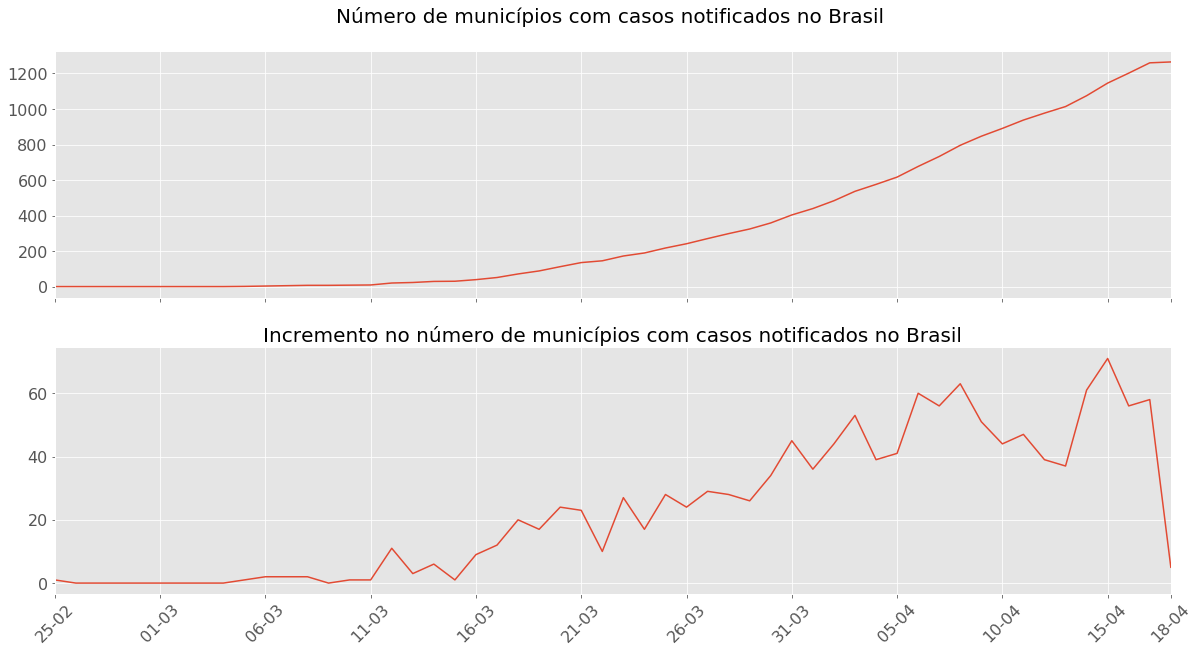

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
ax[0].plot(series_contagem_municipios_afetados)
ax[0].set_title('Número de municípios com casos notificados no Brasil \n')

datas_total = np.array(series_contagem_municipios_afetados.index)
xticks_datas = np.array(series_contagem_municipios_afetados.index[::5])
xticks_posicao = np.where(np.isin(datas_total, xticks_datas))[0]
plt.xticks(np.append(xticks_posicao, len(series_contagem_municipios_afetados.index) - 1), rotation=45)


plt.xlim(left=0, right=len(series_contagem_municipios_afetados.index) - 1)

#plt.ylim(bottom=0);


serie_incremento_municipios_afetados = series_contagem_municipios_afetados.diff().fillna(1)

ax[1].plot(serie_incremento_municipios_afetados)

ax[1].set_title('Incremento no número de municípios com casos notificados no Brasil');

In [76]:
gdf_ufs = gpd.read_file('zip://br_unidades_da_federacao.zip', encoding='utf-8')
gdf_ufs

,NM_ESTADO,NM_REGIAO,CD_GEOCUF,geometry
0,ACRE,NORTE,12,"POLYGON ((-73.18253 -7.33550, -73.05413 -7.381..."
1,ALAGOAS,NORDESTE,27,"POLYGON ((-35.46659 -8.81764, -35.46658 -8.817..."
2,AMAPÁ,NORTE,16,"MULTIPOLYGON (((-50.18123 1.90099, -50.17688 1..."
3,BAHIA,NORDESTE,29,"MULTIPOLYGON (((-38.65484 -18.04242, -38.65819..."
4,CEARÁ,NORDESTE,23,"POLYGON ((-40.49717 -2.78451, -40.49173 -2.788..."
5,DISTRITO FEDERAL,CENTRO-OESTE,53,"POLYGON ((-48.05328 -15.50026, -48.03611 -15.5..."
6,ESPÍRITO SANTO,SUDESTE,32,"MULTIPOLYGON (((-40.39595 -20.62216, -40.39617..."
7,GOIÁS,CENTRO-OESTE,52,"POLYGON ((-50.16015 -12.42007, -50.15836 -12.4..."
8,MARANHÃO,NORDESTE,21,"MULTIPOLYGON (((-43.99913 -2.39272, -43.99937 ..."
9,MATO GROSSO,CENTRO-OESTE,51,"POLYGON ((-57.93439 -7.65677, -57.93044 -7.657..."


In [78]:
gdf_municipios_br = gpd.read_file('zip://br_municipios.zip', encoding='utf-8')

# Renomeia as colunas do Geo Data Frame
gdf_municipios_br.columns = ['municipio', 'cod_mun', 'geometry']

# Altera o tipo da coluna cod_mun no Geo Data Frame para integer
gdf_municipios_br.cod_mun  = pd.to_numeric(gdf_municipios_br.cod_mun, downcast='integer')

gdf_municipios_br

,municipio,cod_mun,geometry
0,CACHOEIRA DO PIRIÁ,1501956,"POLYGON ((-46.31955 -1.75518, -46.31990 -1.755..."
1,SÃO JOSÉ DOS BASÍLIOS,2111250,"POLYGON ((-44.63409 -5.03498, -44.63407 -5.034..."
2,APARECIDA DO RIO DOCE,5201454,"POLYGON ((-51.14230 -18.29672, -51.14236 -18.2..."
3,ARENÓPOLIS,5202353,"POLYGON ((-51.69953 -16.23270, -51.69957 -16.2..."
4,CURUÁ,1502855,"POLYGON ((-55.17193 -1.83331, -55.16647 -1.731..."
...,...,...,...
5567,PARAGUAÇU PAULISTA,3535507,"POLYGON ((-50.69420 -22.39885, -50.69410 -22.3..."
5568,ÁGUA LIMPA,5200209,"POLYGON ((-48.86197 -17.98972, -48.86111 -17.9..."
5569,SANTA CRUZ DO SUL,4316808,"POLYGON ((-52.46848 -29.70647, -52.46847 -29.7..."
5570,SAUDADES,4217303,"POLYGON ((-53.10221 -26.93414, -53.10236 -26.9..."


In [85]:
gdf_municipios_br = gdf_municipios_br.merge(df_fatores_geograficos, on='cod_mun')

In [86]:
gdf_municipios_br

,municipio,cod_mun,geometry,UF,Município,pop2019,pib2017milreais,export_fob_2019,import_fob_2019,pip_per_capita17,...,dia1104,dia1204,dia1304,dia1404,dia1504,dia1604,dia1704,dia1804,data_primeiro_caso,dias_contaminação_referencia
0,CACHOEIRA DO PIRIÁ,1501956,"POLYGON ((-46.31955 -1.75518, -46.31990 -1.755...",PA,Cachoeira do Piriá,33900,188108,0,0,5710,...,0,0,0,0,0,0,0,0,NaN,nan
1,SÃO JOSÉ DOS BASÍLIOS,2111250,"POLYGON ((-44.63409 -5.03498, -44.63407 -5.034...",MA,São José dos Basílios,7641,52386,0,0,7000,...,0,0,0,0,0,0,0,0,NaN,nan
2,APARECIDA DO RIO DOCE,5201454,"POLYGON ((-51.14230 -18.29672, -51.14236 -18.2...",GO,Aparecida do Rio Doce,2474,88019,0,0,34970,...,0,0,0,0,0,0,0,0,NaN,nan
3,ARENÓPOLIS,5202353,"POLYGON ((-51.69953 -16.23270, -51.69957 -16.2...",GO,Arenópolis,2612,125291,0,0,42370,...,0,0,0,0,0,0,0,0,NaN,nan
4,CURUÁ,1502855,"POLYGON ((-55.17193 -1.83331, -55.16647 -1.731...",PA,Curuá,14393,120940,0,0,8640,...,0,0,0,0,0,0,0,0,NaN,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5565,PARAGUAÇU PAULISTA,3535507,"POLYGON ((-50.69420 -22.39885, -50.69410 -22.3...",SP,Paraguaçu Paulista,45703,1235133,60758223,12477487,27290,...,0,0,0,0,0,0,0,0,NaN,nan
5566,ÁGUA LIMPA,5200209,"POLYGON ((-48.86197 -17.98972, -48.86111 -17.9...",GO,Água Limpa,1850,44385,0,0,22560,...,0,0,0,0,0,0,0,0,NaN,nan
5567,SANTA CRUZ DO SUL,4316808,"POLYGON ((-52.46848 -29.70647, -52.46847 -29.7...",RS,Santa Cruz do Sul,130416,8238767,1113326583,98390060,64650,...,1,1,1,1,1,1,1,1,05/04/2020,41.0000
5568,SAUDADES,4217303,"POLYGON ((-53.10221 -26.93414, -53.10236 -26.9...",SC,Saudades,9745,324652,8190101,7525925,33590,...,0,0,0,0,0,0,0,0,NaN,nan


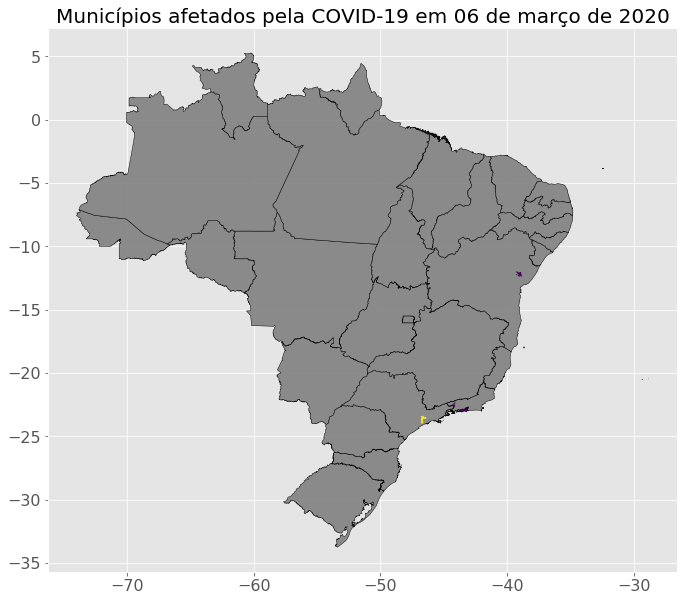

In [115]:
fig, ax = plt.subplots()



ax.set_aspect('equal')


gdf_ufs.geometry.plot(ax=ax, color='gray', edgecolor='k', alpha=0.9)
gdf_municipios_br[gdf_municipios_br['dia0603'] != 0].plot(column='dia0603', ax=ax)

plt.title('Municípios afetados pela COVID-19 em 06 de março de 2020')

plt.show();

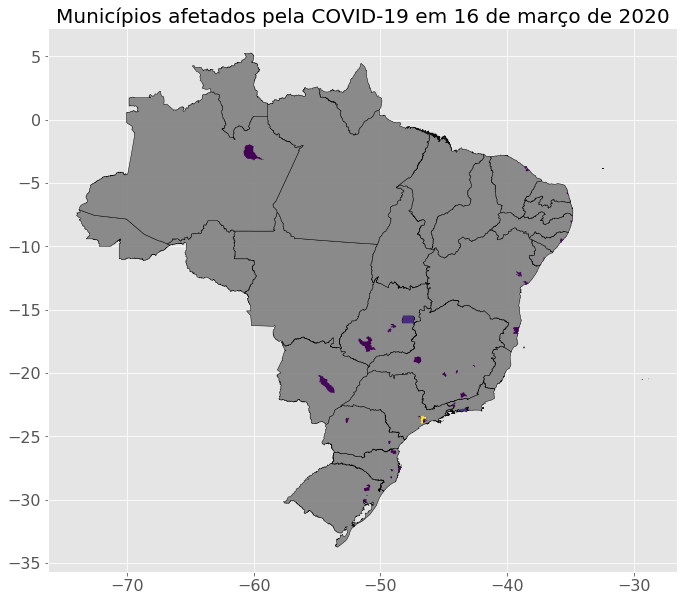

In [116]:
fig, ax = plt.subplots()

ax.set_aspect('equal')


gdf_ufs.geometry.plot(ax=ax, color='gray', edgecolor='k', alpha=0.9)
gdf_municipios_br[gdf_municipios_br['dia1603'] != 0].plot(column='dia1603', ax=ax)

plt.title('Municípios afetados pela COVID-19 em 16 de março de 2020')

plt.show();

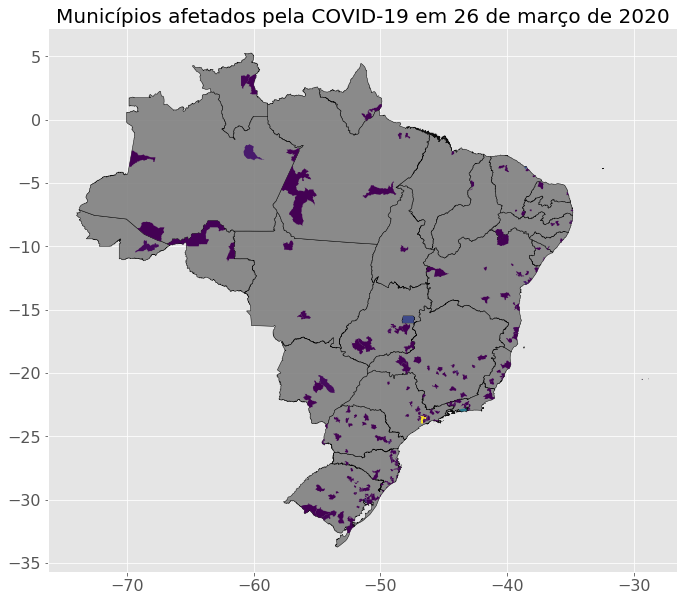

In [117]:
fig, ax = plt.subplots()

ax.set_aspect('equal')


gdf_ufs.geometry.plot(ax=ax, color='gray', edgecolor='k', alpha=0.9)
gdf_municipios_br[gdf_municipios_br['dia2603'] != 0].plot(column='dia2603', ax=ax)
plt.title('Municípios afetados pela COVID-19 em 26 de março de 2020')
plt.show();

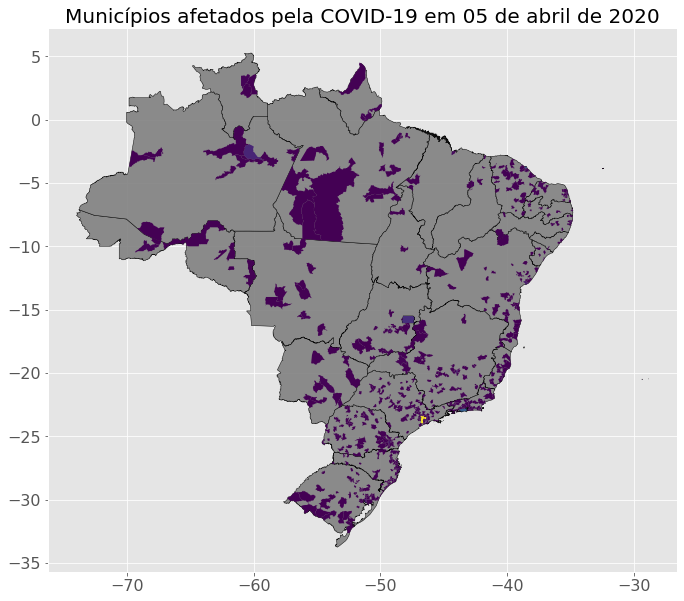

In [118]:
fig, ax = plt.subplots()

ax.set_aspect('equal')


gdf_ufs.geometry.plot(ax=ax, color='gray', edgecolor='k', alpha=0.9)
gdf_municipios_br[gdf_municipios_br['dia0504'] != 0].plot(column='dia0504', ax=ax)
plt.title('Municípios afetados pela COVID-19 em 05 de abril de 2020')
plt.show();

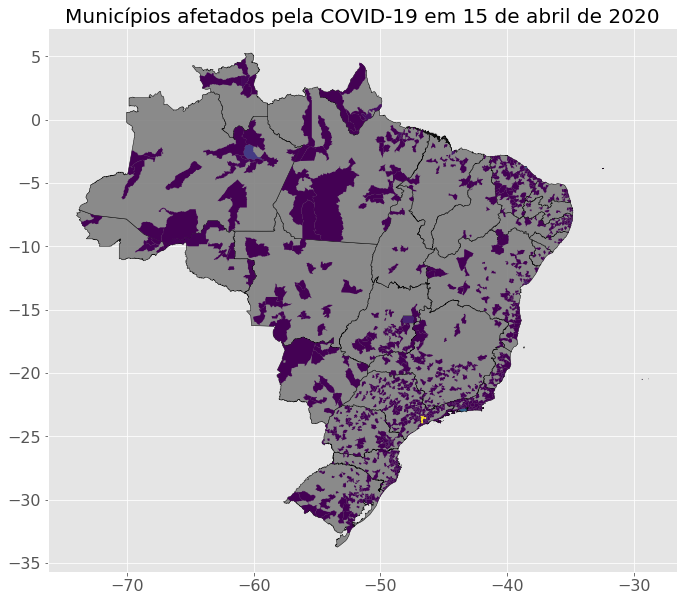

In [119]:
fig, ax = plt.subplots()

ax.set_aspect('equal')


gdf_ufs.geometry.plot(ax=ax, color='gray', edgecolor='k', alpha=0.9)
gdf_municipios_br[gdf_municipios_br['dia1504'] != 0].plot(column='dia1504', ax=ax)
plt.title('Municípios afetados pela COVID-19 em 15 de abril de 2020')
plt.show();

### DIFUSÃO DA COVID-19 SEGUNDO NÍVEL DE CENTRALIDADE DOS MUNICÍPIOS

**Geração de Data Frames de nível de centralidade municípios afetados**

In [13]:
df_hierarquia, df_hierarquia_fracao = conta_municipios_por_classe(col='hierarquia')

df_hierarquia.columns = ['Centro Local','Centro de Zona B', 'Centro de Zona A', 
                          'Centro Subregional B', 'Centro Subregional A', 
                          'Capital Regional C', 'Capital Regional B', 
                          'Capital Regional A', 'Metrópole','Metrópole Nacional', 
                          'Grande Metrópole Nacional']

df_hierarquia.columns.name = 'hierarquia'

df_hierarquia_fracao.columns = ['Centro Local','Centro de Zona B', 'Centro de Zona A', 
                          'Centro Subregional B', 'Centro Subregional A', 
                          'Capital Regional C', 'Capital Regional B', 
                          'Capital Regional A', 'Metrópole','Metrópole Nacional', 
                          'Grande Metrópole Nacional']

df_hierarquia_fracao.columns.name = 'hierarquia'


In [14]:
df_hierarquia.tail()

hierarquia,Centro Local,Centro de Zona B,Centro de Zona A,Centro Subregional B,Centro Subregional A,Capital Regional C,Capital Regional B,Capital Regional A,Metrópole,Metrópole Nacional,Grande Metrópole Nacional
data,,,,,,,,,,,
2020-04-14,469.0000,104.0000,106.0000,51.0000,70.0000,70.0000,35.0000,47.0000,77.0000,25.0000,39.0000
2020-04-15,519.0000,113.0000,110.0000,53.0000,72.0000,70.0000,35.0000,51.0000,77.0000,26.0000,40.0000
2020-04-16,560.0000,118.0000,115.0000,54.0000,73.0000,70.0000,35.0000,52.0000,79.0000,26.0000,41.0000
2020-04-17,600.0000,124.0000,122.0000,57.0000,73.0000,70.0000,35.0000,52.0000,80.0000,26.0000,42.0000
2020-04-18,602.0000,126.0000,122.0000,57.0000,73.0000,70.0000,35.0000,52.0000,80.0000,26.0000,42.0000


In [15]:
df_hierarquia.tail()

hierarquia,Centro Local,Centro de Zona B,Centro de Zona A,Centro Subregional B,Centro Subregional A,Capital Regional C,Capital Regional B,Capital Regional A,Metrópole,Metrópole Nacional,Grande Metrópole Nacional
data,,,,,,,,,,,
2020-04-14,469.0000,104.0000,106.0000,51.0000,70.0000,70.0000,35.0000,47.0000,77.0000,25.0000,39.0000
2020-04-15,519.0000,113.0000,110.0000,53.0000,72.0000,70.0000,35.0000,51.0000,77.0000,26.0000,40.0000
2020-04-16,560.0000,118.0000,115.0000,54.0000,73.0000,70.0000,35.0000,52.0000,79.0000,26.0000,41.0000
2020-04-17,600.0000,124.0000,122.0000,57.0000,73.0000,70.0000,35.0000,52.0000,80.0000,26.0000,42.0000
2020-04-18,602.0000,126.0000,122.0000,57.0000,73.0000,70.0000,35.0000,52.0000,80.0000,26.0000,42.0000


**Gráfico: Razão de municípios com casos notificados por total de municípios segundo hierarquia urbano-regional**

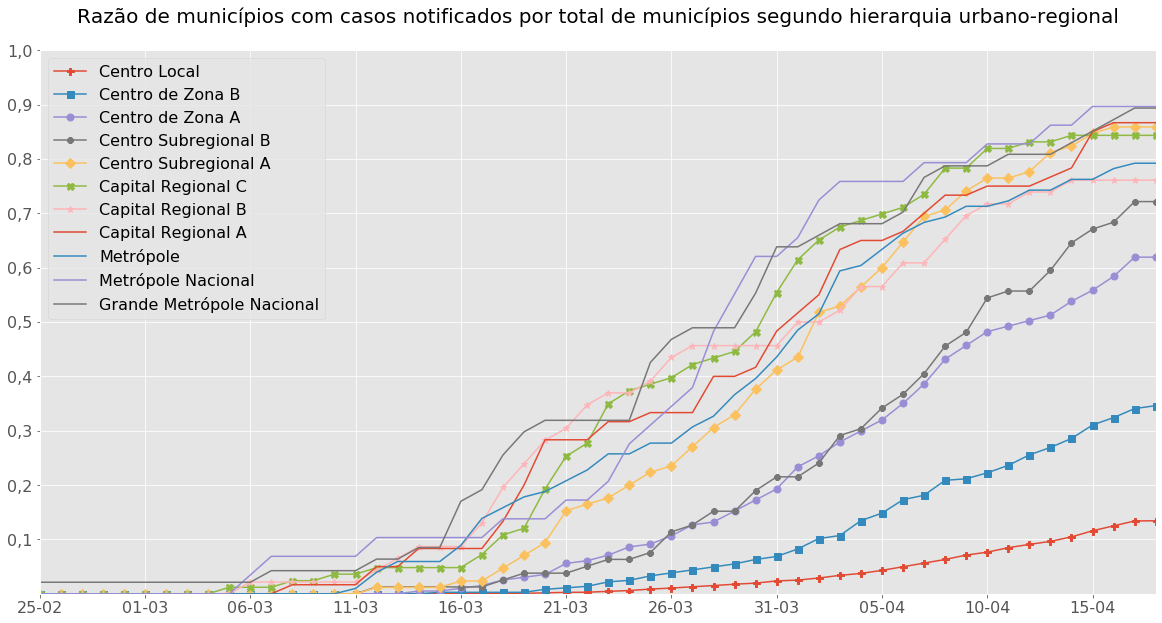

In [16]:
plot_razao_municipios_afetados(df=df_hierarquia_fracao, titulo='Razão de municípios com casos notificados por total de municípios segundo hierarquia urbano-regional', save_fig=None)

### DIFUSÃO DA COVID-19 SEGUNDO CLASSES DE PATAMAR POPULACINAL DOS MUNICÍPIOS

**Geração de Data Frames de patamar populacional e municípios afetados**

In [17]:

df_classes_pop, df_classes_pop_fracao = conta_municipios_por_classe(col='classe_pop')

df_classes_pop.columns = ['até 20.000', 'de 20.000 até 50.000','de 50.000 até 100.000', 
                          'de 100.000 até 500.000', 'de 500.000 até 1.000.000', 'acima de 1.000.000']

df_classes_pop.columns.name = 'classe_pop'

df_classes_pop_fracao.columns = ['até 20.000', 'de 20.000 até 50.000','de 50.000 até 100.000', 
                                 'de 100.000 até 500.000', 'de 500.000 até 1.000.000', 'acima de 1.000.000']

df_classes_pop_fracao.columns.name = 'classe_pop'

In [18]:
df_classes_pop.tail()

classe_pop,até 20.000,de 20.000 até 50.000,de 50.000 até 100.000,de 100.000 até 500.000,de 500.000 até 1.000.000,acima de 1.000.000
data,,,,,,
2020-04-14,269.0000,304.0000,212.0000,260.0000,31.0000,17.0000
2020-04-15,294.0000,331.0000,231.0000,262.0000,31.0000,17.0000
2020-04-16,320.0000,351.0000,240.0000,264.0000,31.0000,17.0000
2020-04-17,342.0000,377.0000,249.0000,265.0000,31.0000,17.0000
2020-04-18,343.0000,379.0000,250.0000,265.0000,31.0000,17.0000


In [19]:
df_classes_pop_fracao.tail()

classe_pop,até 20.000,de 20.000 até 50.000,de 50.000 até 100.000,de 100.000 até 500.000,de 500.000 até 1.000.000,acima de 1.000.000
data,,,,,,
2020-04-14,0.0709,0.2761,0.6074,0.9420,1.0000,1.0000
2020-04-15,0.0774,0.3006,0.6619,0.9493,1.0000,1.0000
2020-04-16,0.0843,0.3188,0.6877,0.9565,1.0000,1.0000
2020-04-17,0.0901,0.3424,0.7135,0.9601,1.0000,1.0000
2020-04-18,0.0904,0.3442,0.7163,0.9601,1.0000,1.0000


**Gráfico: Razão de municípios com casos notificados por total de municípios em classes de patamar populacional**

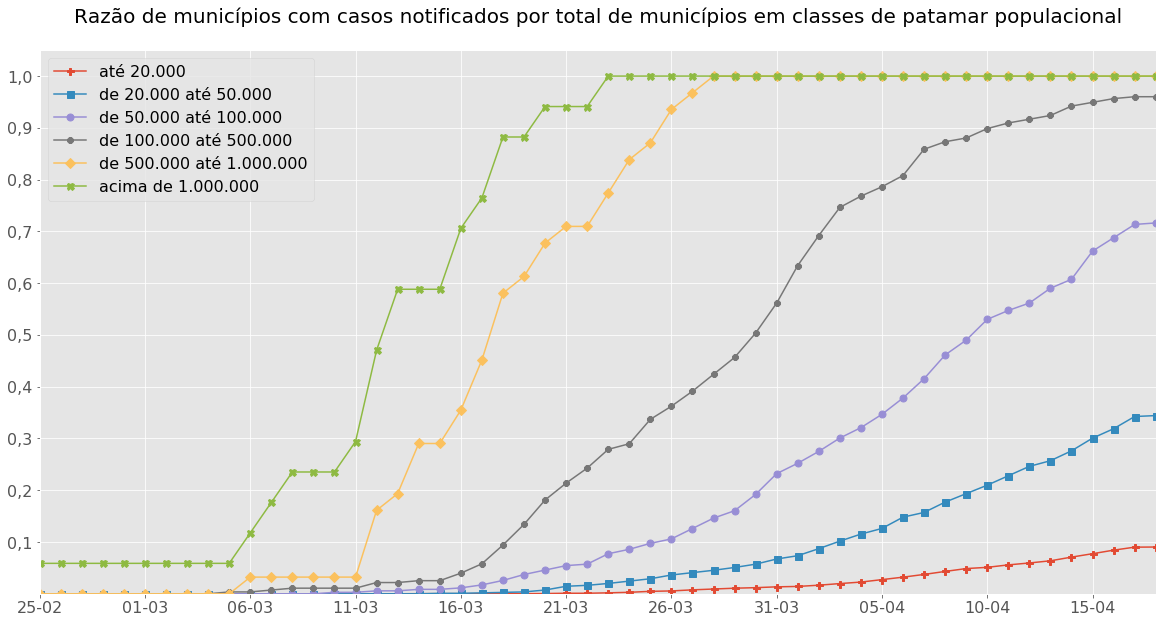

In [20]:
plot_razao_municipios_afetados(df=df_classes_pop_fracao, titulo='Razão de municípios com casos notificados por total de municípios em classes de patamar populacional', save_fig=None)

### DIFUSÃO DA COVID-19 SEGUNDO CLASSES DE PATAMAR DO PIB DOS MUNICÍPIOS

**Geração de Data Frames de patamar de PIB e municípios afetados**

In [21]:
df_classes_pib, df_classes_pib_fracao = conta_municipios_por_classe(col='classe_pib')

df_classes_pib.columns = df_classes_pib.columns.str.slice(start=4)

df_classes_pib_fracao.columns = df_classes_pib_fracao.columns.str.slice(start=4)

In [22]:
df_classes_pib.tail()

classe_pib,até 50,de 50 a 100,de 100 a 500,de 500 a 1.000,de 1.000 a 5.000,de 5.000 a 10.000,de 10.000 a 20.000,acima de 20.000
data,,,,,,,,
2020-04-14,12.0000,53.0000,312.0000,168.0000,386.0000,64.0000,56.0000,42.0000
2020-04-15,14.0000,56.0000,352.0000,180.0000,402.0000,64.0000,56.0000,42.0000
2020-04-16,17.0000,57.0000,383.0000,190.0000,414.0000,64.0000,56.0000,42.0000
2020-04-17,21.0000,60.0000,417.0000,200.0000,421.0000,64.0000,56.0000,42.0000
2020-04-18,21.0000,60.0000,419.0000,201.0000,422.0000,64.0000,56.0000,42.0000


In [23]:
df_classes_pib_fracao.tail()

classe_pib,até 50,de 50 a 100,de 100 a 500,de 500 a 1.000,de 1.000 a 5.000,de 5.000 a 10.000,de 10.000 a 20.000,acima de 20.000
data,,,,,,,,
2020-04-14,0.0173,0.0478,0.1275,0.2995,0.6466,0.9846,1.0000,1.0000
2020-04-15,0.0202,0.0505,0.1438,0.3209,0.6734,0.9846,1.0000,1.0000
2020-04-16,0.0245,0.0514,0.1565,0.3387,0.6935,0.9846,1.0000,1.0000
2020-04-17,0.0303,0.0541,0.1704,0.3565,0.7052,0.9846,1.0000,1.0000
2020-04-18,0.0303,0.0541,0.1712,0.3583,0.7069,0.9846,1.0000,1.0000


**Gráfico: Razão de municípios com casos notificados por total de municípios em classes de patamar do PIB (milhões R$) em 2017**

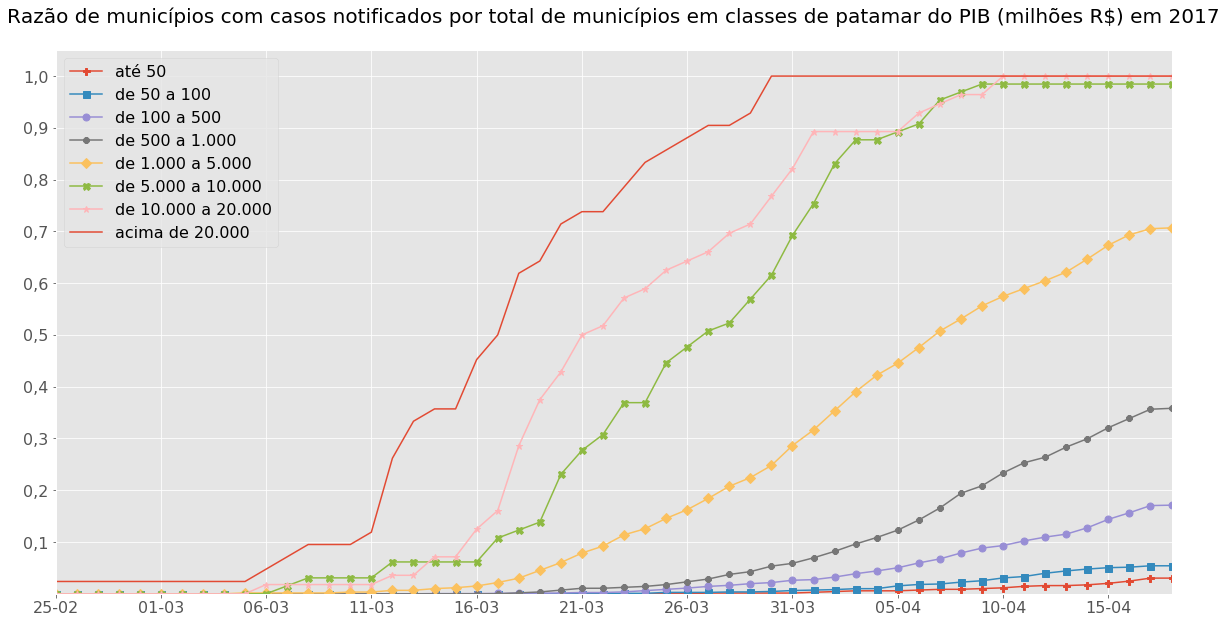

In [24]:
plot_razao_municipios_afetados(df=df_classes_pib_fracao, titulo='Razão de municípios com casos notificados por total de municípios em classes de patamar do PIB (milhões R$) em 2017', save_fig=None)

### DIFUSÃO DA COVID-19 SEGUNDO CLASSES DE PIB *PER CAPITA* DOS MUNICÍPIOS

**Geração de Data Frames de PIB _per capita_ e municípios afetados**

In [25]:
df_classes_capita, df_classes_capita_fracao = conta_municipios_por_classe(col='classe_capita')

df_classes_capita.columns = df_classes_capita.columns.str.slice(start=4)

df_classes_capita_fracao.columns = df_classes_capita_fracao.columns.str.slice(start=4)

In [26]:
df_classes_capita.tail()

classe_capita,até 10.000,de 10.000 a 20.000,de 20.000 a 30.000,de 30.000 a 40.000,de 40.000 a 50.000,de 50.000 a 100.000,Acima de 10.000
data,,,,,,,
2020-04-14,145.0000,312.0000,251.0000,180.0000,100.0000,83.0000,22.0000
2020-04-15,167.0000,335.0000,266.0000,186.0000,105.0000,85.0000,22.0000
2020-04-16,181.0000,360.0000,273.0000,189.0000,109.0000,88.0000,23.0000
2020-04-17,201.0000,380.0000,283.0000,194.0000,111.0000,89.0000,23.0000
2020-04-18,201.0000,382.0000,285.0000,194.0000,111.0000,89.0000,23.0000


In [27]:
df_classes_capita_fracao.tail()

classe_capita,até 10.000,de 10.000 a 20.000,de 20.000 a 30.000,de 30.000 a 40.000,de 40.000 a 50.000,de 50.000 a 100.000,Acima de 10.000
data,,,,,,,
2020-04-14,0.0941,0.1785,0.2229,0.3279,0.3610,0.3063,0.3793
2020-04-15,0.1084,0.1916,0.2362,0.3388,0.3791,0.3137,0.3793
2020-04-16,0.1175,0.2059,0.2425,0.3443,0.3935,0.3247,0.3966
2020-04-17,0.1304,0.2174,0.2513,0.3534,0.4007,0.3284,0.3966
2020-04-18,0.1304,0.2185,0.2531,0.3534,0.4007,0.3284,0.3966


**Gráfico: Razão de municípios com casos notificados por total de municípios em classes de PIB _per capita_**

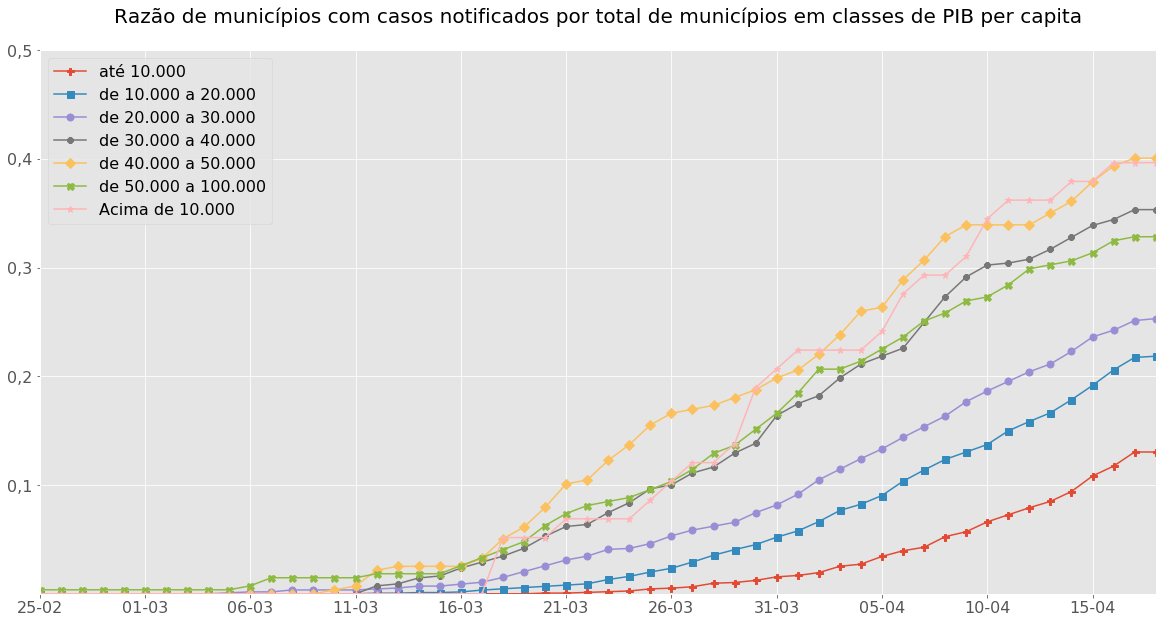

In [28]:
plot_razao_municipios_afetados(df=df_classes_capita_fracao, titulo='Razão de municípios com casos notificados por total de municípios em classes de PIB per capita', save_fig=None)


plt.ylim(top=0.5);

### DIFUSÃO DA COVID-19 SEGUNDO CLASSES DE EXPORTAÇÃO DOS MUNICÍPIOS

**Geração de Data Frames de exportação e municípios afetados**

In [29]:
df_classes_exp, df_classes_exp_fracao = conta_municipios_por_classe(col='classe_exportacao')

df_classes_exp = df_classes_exp[['1 - Sem exportações', '2 - até 50.000','3 - de 50.000 a 200.000', '4 - de 200.000 a 500.000', '5 - de 500.000 a 1.000.000', '6 - de 1.000.000 a 5.000.000', '7 - de 5.000.000 a 20.000.000', '8 - de 20.000.000 a 50.000.000','9 - de 50.000.000 a 100.000.000', '10 - de 100.000.000 a 500.000.000','11 - acima de 500.000.000']]


df_classes_exp_fracao = df_classes_exp_fracao[['1 - Sem exportações', '2 - até 50.000','3 - de 50.000 a 200.000', '4 - de 200.000 a 500.000', '5 - de 500.000 a 1.000.000', '6 - de 1.000.000 a 5.000.000', '7 - de 5.000.000 a 20.000.000', '8 - de 20.000.000 a 50.000.000','9 - de 50.000.000 a 100.000.000', '10 - de 100.000.000 a 500.000.000','11 - acima de 500.000.000']]

df_classes_exp.columns = df_classes_exp.columns.str.slice(start=4)

df_classes_exp_fracao.columns = df_classes_exp_fracao.columns.str.slice(start=4)

In [30]:
df_classes_exp.tail()

classe_exportacao,Sem exportações,até 50.000,de 50.000 a 200.000,de 200.000 a 500.000,de 500.000 a 1.000.000,de 1.000.000 a 5.000.000,de 5.000.000 a 20.000.000,de 20.000.000 a 50.000.000,de 50.000.000 a 100.000.000,de 100.000.000 a 500.000.000,acima de 500.000.000
data,,,,,,,,,,,
2020-04-14,301.0000,65.0000,29.0000,43.0000,41.0000,87.0000,124.0000,93.0000,91.0000,141.0000,78.0000
2020-04-15,336.0000,67.0000,32.0000,45.0000,47.0000,96.0000,129.0000,95.0000,95.0000,145.0000,79.0000
2020-04-16,367.0000,69.0000,35.0000,46.0000,50.0000,100.0000,134.0000,99.0000,97.0000,146.0000,80.0000
2020-04-17,402.0000,71.0000,39.0000,47.0000,51.0000,104.0000,138.0000,103.0000,98.0000,147.0000,81.0000
2020-04-18,402.0000,71.0000,39.0000,47.0000,51.0000,104.0000,139.0000,105.0000,98.0000,148.0000,81.0000


In [31]:
df_classes_exp_fracao.tail()

classe_exportacao,Sem exportações,até 50.000,de 50.000 a 200.000,de 200.000 a 500.000,de 500.000 a 1.000.000,de 1.000.000 a 5.000.000,de 5.000.000 a 20.000.000,de 20.000.000 a 50.000.000,de 50.000.000 a 100.000.000,de 100.000.000 a 500.000.000,acima de 500.000.000
data,,,,,,,,,,,
2020-04-14,0.0892,0.2372,0.1620,0.2671,0.2628,0.2559,0.3573,0.3924,0.5141,0.6078,0.8387
2020-04-15,0.0996,0.2445,0.1788,0.2795,0.3013,0.2824,0.3718,0.4008,0.5367,0.6250,0.8495
2020-04-16,0.1088,0.2518,0.1955,0.2857,0.3205,0.2941,0.3862,0.4177,0.5480,0.6293,0.8602
2020-04-17,0.1191,0.2591,0.2179,0.2919,0.3269,0.3059,0.3977,0.4346,0.5537,0.6336,0.8710
2020-04-18,0.1191,0.2591,0.2179,0.2919,0.3269,0.3059,0.4006,0.4430,0.5537,0.6379,0.8710


**Gráfico: Razão de municípios com casos notificados por total de municípios em classes de exportação (U$ FOB)**

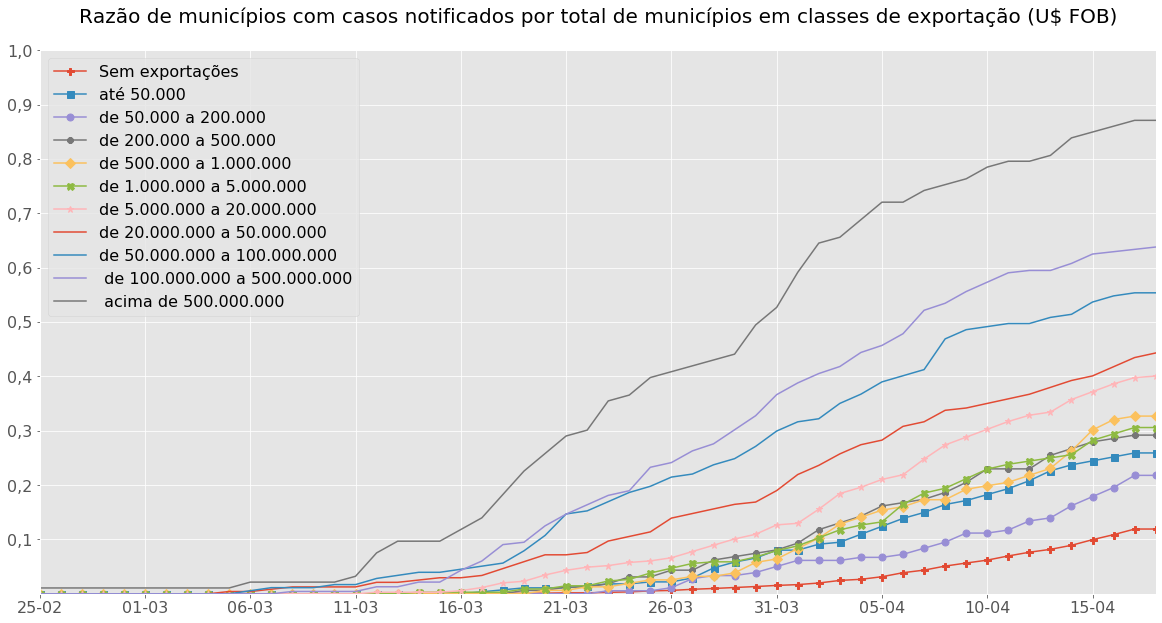

In [32]:
plot_razao_municipios_afetados(df=df_classes_exp_fracao, titulo='Razão de municípios com casos notificados por total de municípios em classes de exportação (U$ FOB)', save_fig=None)

### DIFUSÃO DA COVID-19 SEGUNDO CLASSES DE IMPORTAÇÃO DOS MUNICÍPIOS

**Geração de Data Frames de patamar de Importação e municípios afetados**

In [33]:
df_classes_imp, df_classes_imp_fracao = conta_municipios_por_classe(col='classe_importacao')

df_classes_imp.columns = df_classes_imp.columns.str.slice(start=4)

df_classes_imp_fracao.columns = df_classes_imp_fracao.columns.str.slice(start=4)

In [34]:
df_classes_imp.tail()

classe_importacao,sem importação,de 2000.000 até 500.000.000,acima de 500.000.000,até 50.000,de 50.000 até 100.000,de 100.000 até 500.000,de 500.000 até 1.000.000,de 1.000.000 até 5.000.000,de 5.000.000 até 10.000.000,de 10.000.000 até 50.000.000,de 50.000.000 até 200.000.000
data,,,,,,,,,,,
2020-04-14,288.0000,59.0000,71.0000,77.0000,27.0000,76.0000,31.0000,134.0000,67.0000,162.0000,101.0000
2020-04-15,321.0000,59.0000,71.0000,90.0000,30.0000,82.0000,35.0000,138.0000,69.0000,164.0000,107.0000
2020-04-16,346.0000,59.0000,72.0000,97.0000,32.0000,84.0000,38.0000,147.0000,71.0000,169.0000,108.0000
2020-04-17,378.0000,59.0000,72.0000,101.0000,33.0000,85.0000,42.0000,154.0000,75.0000,172.0000,110.0000
2020-04-18,378.0000,59.0000,72.0000,102.0000,33.0000,85.0000,43.0000,155.0000,75.0000,173.0000,110.0000


In [35]:
df_classes_imp_fracao.tail()

classe_importacao,sem importação,de 2000.000 até 500.000.000,acima de 500.000.000,até 50.000,de 50.000 até 100.000,de 100.000 até 500.000,de 500.000 até 1.000.000,de 1.000.000 até 5.000.000,de 5.000.000 até 10.000.000,de 10.000.000 até 50.000.000,de 50.000.000 até 200.000.000
data,,,,,,,,,,,
2020-04-14,0.0812,0.9219,0.9467,0.1833,0.2348,0.2686,0.2214,0.3681,0.4110,0.6136,0.7537
2020-04-15,0.0905,0.9219,0.9467,0.2143,0.2609,0.2898,0.2500,0.3791,0.4233,0.6212,0.7985
2020-04-16,0.0975,0.9219,0.9600,0.2310,0.2783,0.2968,0.2714,0.4038,0.4356,0.6402,0.8060
2020-04-17,0.1065,0.9219,0.9600,0.2405,0.2870,0.3004,0.3000,0.4231,0.4601,0.6515,0.8209
2020-04-18,0.1065,0.9219,0.9600,0.2429,0.2870,0.3004,0.3071,0.4258,0.4601,0.6553,0.8209


**Gráfico: Razão de municípios com casos notificados por total de municípios em classes de importação (U$ FOB)**

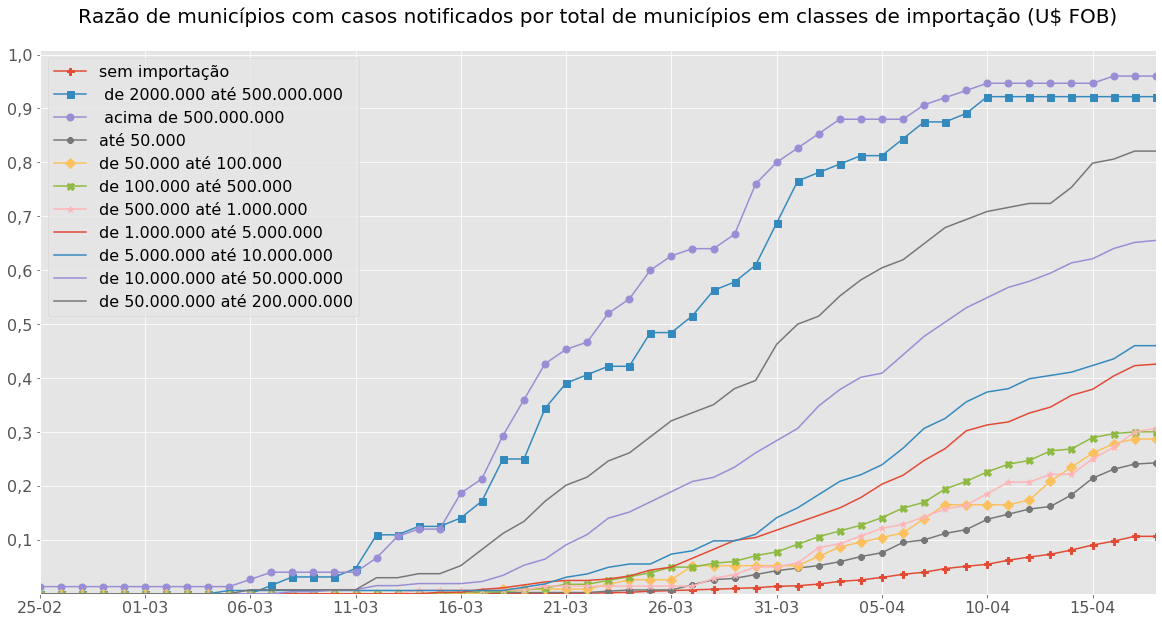

In [36]:
plot_razao_municipios_afetados(df=df_classes_imp_fracao, titulo='Razão de municípios com casos notificados por total de municípios em classes de importação (U$ FOB)', save_fig=None)

### DIFUSÃO DA COVID-19 SEGUNDO CLASSES DE PROXIMIDADE RODOVIÁRIA/HIDROVIÁRIA DOS MUNICÍPIOS

**Geração de Data Frames de classes de proximidade rodoviária/hidroviária e municípios afetados**

In [37]:
df_classes_proximidade, df_classes_proximidade_fracao = conta_municipios_por_classe(col='classe_proximidade')

df_classes_proximidade.columns = df_classes_proximidade_fracao.columns.str.slice(start=4)

df_classes_proximidade_fracao.columns = df_classes_proximidade_fracao.columns.str.slice(start=4)

In [38]:
df_classes_proximidade.tail()

classe_proximidade,0,"0,20 a 0,25","0,25 a 0,30","0,30 a 0,35","0,35 a 0,40","0,40 a 0,45","acima de 0,45"
data,,,,,,,
2020-04-14,45.0000,42.0000,133.0000,325.0000,409.0000,124.0000,15.0000
2020-04-15,47.0000,43.0000,141.0000,362.0000,432.0000,126.0000,15.0000
2020-04-16,48.0000,47.0000,154.0000,376.0000,455.0000,128.0000,15.0000
2020-04-17,49.0000,49.0000,166.0000,398.0000,476.0000,128.0000,15.0000
2020-04-18,49.0000,49.0000,166.0000,399.0000,479.0000,128.0000,15.0000


In [39]:
df_classes_proximidade_fracao.tail()

classe_proximidade,0,"0,20 a 0,25","0,25 a 0,30","0,30 a 0,35","0,35 a 0,40","0,40 a 0,45","acima de 0,45"
data,,,,,,,
2020-04-14,0.2446,0.2295,0.0962,0.1422,0.3071,0.6561,1.0000
2020-04-15,0.2554,0.2350,0.1020,0.1584,0.3243,0.6667,1.0000
2020-04-16,0.2609,0.2568,0.1114,0.1646,0.3416,0.6772,1.0000
2020-04-17,0.2663,0.2678,0.1201,0.1742,0.3574,0.6772,1.0000
2020-04-18,0.2663,0.2678,0.1201,0.1746,0.3596,0.6772,1.0000


**Razão de municípios com casos notificados por total de municípios em classes de proximidade rodoviária/hidroviária**

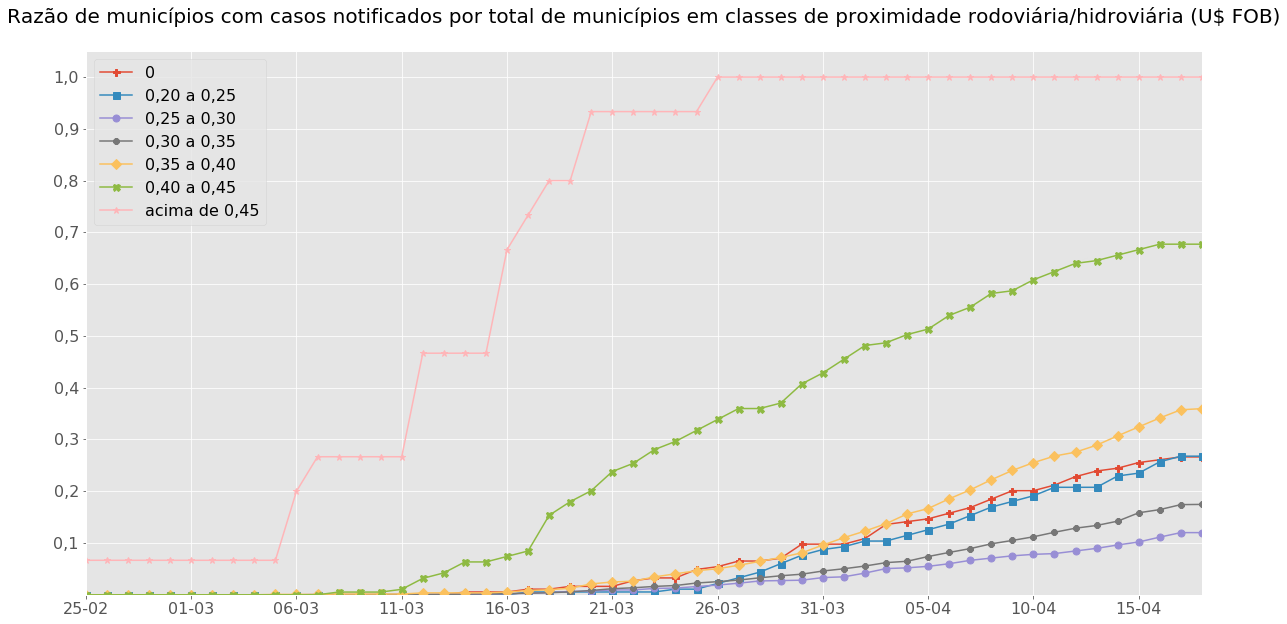

In [40]:
plot_razao_municipios_afetados(df=df_classes_proximidade_fracao, titulo='Razão de municípios com casos notificados por total de municípios em classes de proximidade rodoviária/hidroviária (U$ FOB)', save_fig=None)

### DIFUSÃO DA COVID-19 SEGUNDO CLASSES DE PASSAGEIROS DE VOOS DOMÉSTICOS NOS MUNICÍPIOS

**Geração de Data Frames de número de passageiros em voos domésticos e municípios afetados**

In [41]:
df_classes_voos_domesticos, df_classes_voos_domesticos_fracao = conta_municipios_por_classe(col='classes_voos_dom_2019')

df_classes_voos_domesticos.columns = df_classes_voos_domesticos.columns.str.slice(start=4)

df_classes_voos_domesticos_fracao.columns = df_classes_voos_domesticos_fracao.columns.str.slice(start=4)

In [42]:
df_classes_voos_domesticos.tail()

classes_voos_dom_2019,sem passageiros,até 1.000,de 1.001 até 10.000,de 10.001 até 100.000,de 100.001 até 1.000.000,a partir de 1.000.001
data,,,,,,
2020-04-14,962.0000,28.0000,13.0000,39.0000,32.0000,19.0000
2020-04-15,1034.0000,29.0000,13.0000,39.0000,32.0000,19.0000
2020-04-16,1090.0000,29.0000,14.0000,39.0000,32.0000,19.0000
2020-04-17,1145.0000,30.0000,15.0000,40.0000,32.0000,19.0000
2020-04-18,1149.0000,30.0000,15.0000,40.0000,32.0000,19.0000


In [43]:
df_classes_voos_domesticos_fracao.tail()

classes_voos_dom_2019,sem passageiros,até 1.000,de 1.001 até 10.000,de 10.001 até 100.000,de 100.001 até 1.000.000,a partir de 1.000.001
data,,,,,,
2020-04-14,0.1784,0.5833,0.5000,0.8125,0.9143,0.9048
2020-04-15,0.1918,0.6042,0.5000,0.8125,0.9143,0.9048
2020-04-16,0.2022,0.6042,0.5385,0.8125,0.9143,0.9048
2020-04-17,0.2124,0.6250,0.5769,0.8333,0.9143,0.9048
2020-04-18,0.2131,0.6250,0.5769,0.8333,0.9143,0.9048


**Gráfico: Razão de municípios com casos notificados por total de municípios em classes de passageiros em voos domésticos**

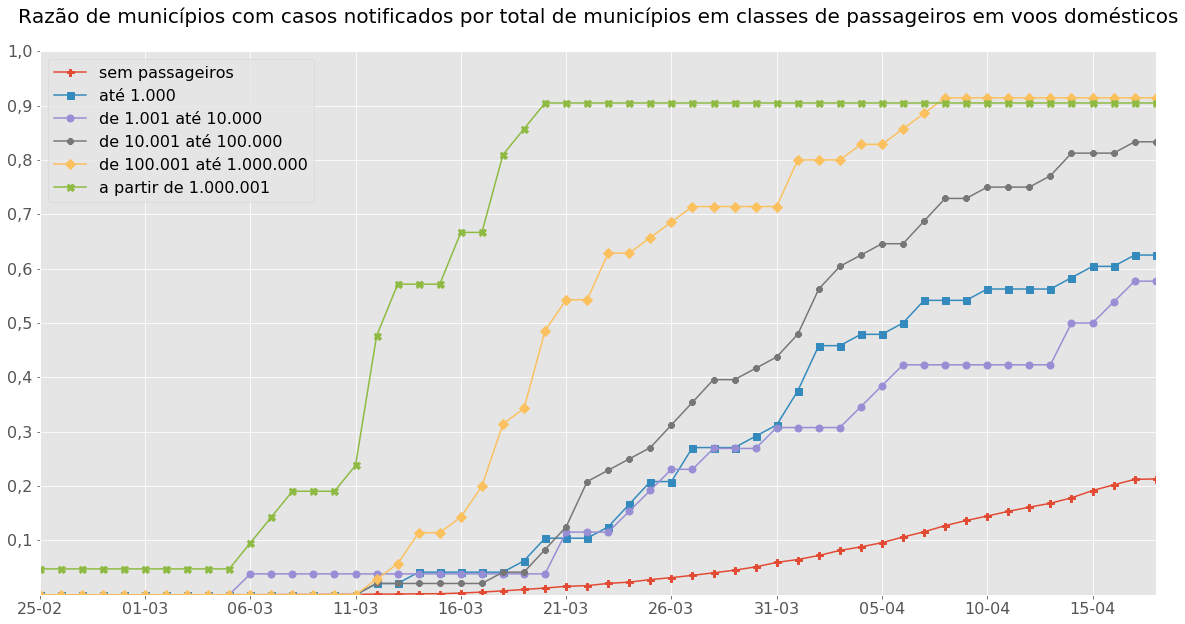

In [44]:
plot_razao_municipios_afetados(df=df_classes_voos_domesticos_fracao, titulo='Razão de municípios com casos notificados por total de municípios em classes de passageiros em voos domésticos', save_fig=None)

### DIFUSÃO DA COVID-19 SEGUNDO CLASSES DE PASSAGEIROS DE VOOS INTERNACIONAIS NOS MUNICÍPIOS

**Geração de Data Frames de número de passageiros em voos internacionais e municípios afetados**

In [45]:
df_classes_voos_int, df_classes_voos_int_fracao = conta_municipios_por_classe(col='classes_voos_int_2019')

df_classes_voos_int.columns = df_classes_voos_int.columns.str.slice(start=4)

df_classes_voos_int_fracao.columns = df_classes_voos_int_fracao.columns.str.slice(start=4)

In [46]:
df_classes_voos_int.tail()

classes_voos_int_2019,sem passageiros,até 1.000,de 1.001 até 20.000,de 20.001 até 100.000,a partir de 100.001
data,,,,,
2020-04-14,1068.0000,5.0000,4.0000,6.0000,10.0000
2020-04-15,1141.0000,5.0000,4.0000,6.0000,10.0000
2020-04-16,1198.0000,5.0000,4.0000,6.0000,10.0000
2020-04-17,1256.0000,5.0000,4.0000,6.0000,10.0000
2020-04-18,1260.0000,5.0000,4.0000,6.0000,10.0000


In [47]:
df_classes_voos_int_fracao.tail()

classes_voos_int_2019,sem passageiros,até 1.000,de 1.001 até 20.000,de 20.001 até 100.000,a partir de 100.001
data,,,,,
2020-04-14,0.1927,0.8333,1.0000,0.7500,1.0000
2020-04-15,0.2059,0.8333,1.0000,0.7500,1.0000
2020-04-16,0.2162,0.8333,1.0000,0.7500,1.0000
2020-04-17,0.2266,0.8333,1.0000,0.7500,1.0000
2020-04-18,0.2274,0.8333,1.0000,0.7500,1.0000


**Gráfico: Razão de municípios com casos notificados por total de municípios em classes de passageiros em voos internacionais**

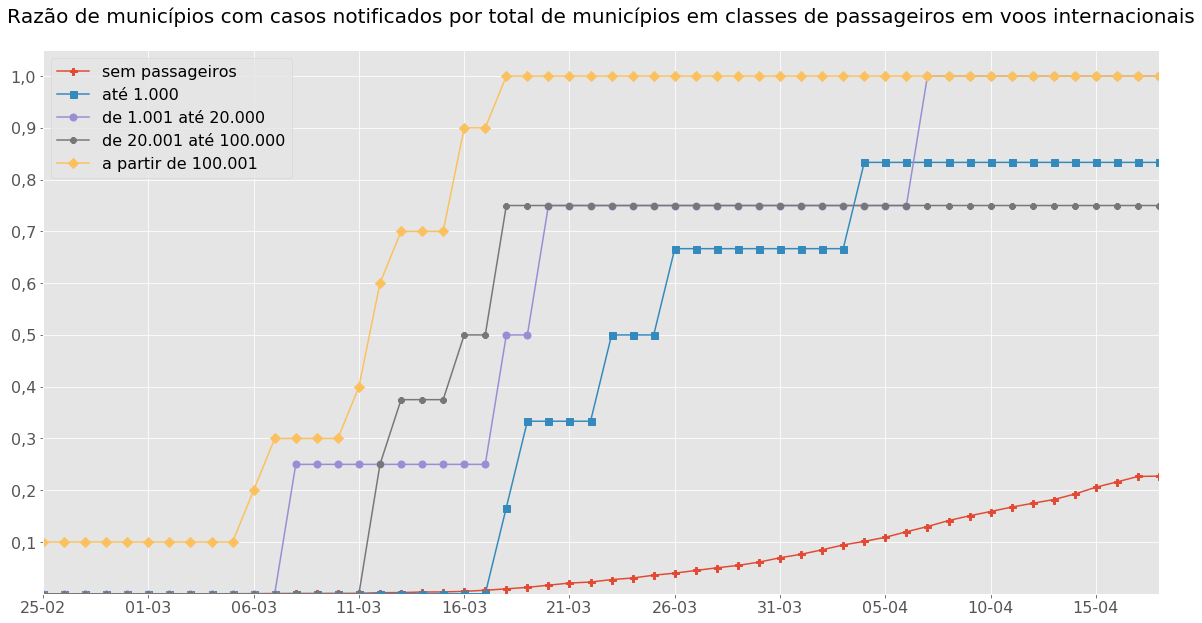

In [48]:
plot_razao_municipios_afetados(df=df_classes_voos_int_fracao, titulo='Razão de municípios com casos notificados por total de municípios em classes de passageiros em voos internacionais', save_fig=None)

### DIFUSÃO DA COVID-19 SEGUNDO CLASSES DE COMPETITIVIDADE DO TURISMO NOS MUNICÍPIOS

**Geração de Data Frames de número de passageiros em voos internacionais e municípios afetados**

In [49]:
df_classes_turismo, df_classes_turismo_fracao = conta_municipios_por_classe(col='turismo')

df_classes_turismo.columns = ['Sem Classe', 'E', 'D', 'C', 'B', 'A']

df_classes_turismo.columns.name = 'turismo'

df_classes_turismo_fracao.columns = ['Sem Classe', 'E', 'D', 'C', 'B', 'A']

df_classes_turismo_fracao.columns.name = 'turismo'

In [50]:
df_classes_turismo.tail()

turismo,Sem Classe,E,D,C,B,A
data,,,,,,
2020-04-14,320.0000,21.0000,257.0000,237.0000,205.0000,53.0000
2020-04-15,352.0000,26.0000,279.0000,249.0000,207.0000,53.0000
2020-04-16,384.0000,26.0000,295.0000,257.0000,208.0000,53.0000
2020-04-17,410.0000,29.0000,310.0000,264.0000,215.0000,53.0000
2020-04-18,410.0000,29.0000,314.0000,264.0000,215.0000,53.0000


In [51]:
df_classes_turismo_fracao.tail()

turismo,Sem Classe,E,D,C,B,A
data,,,,,,
2020-04-14,0.1113,0.0557,0.1689,0.4979,0.7977,0.8548
2020-04-15,0.1224,0.0690,0.1833,0.5231,0.8054,0.8548
2020-04-16,0.1335,0.0690,0.1938,0.5399,0.8093,0.8548
2020-04-17,0.1426,0.0769,0.2037,0.5546,0.8366,0.8548
2020-04-18,0.1426,0.0769,0.2063,0.5546,0.8366,0.8548


**Gráfico: Razão de municípios com casos notificados por total de municípios em classes de passageiros em voos internacionais**

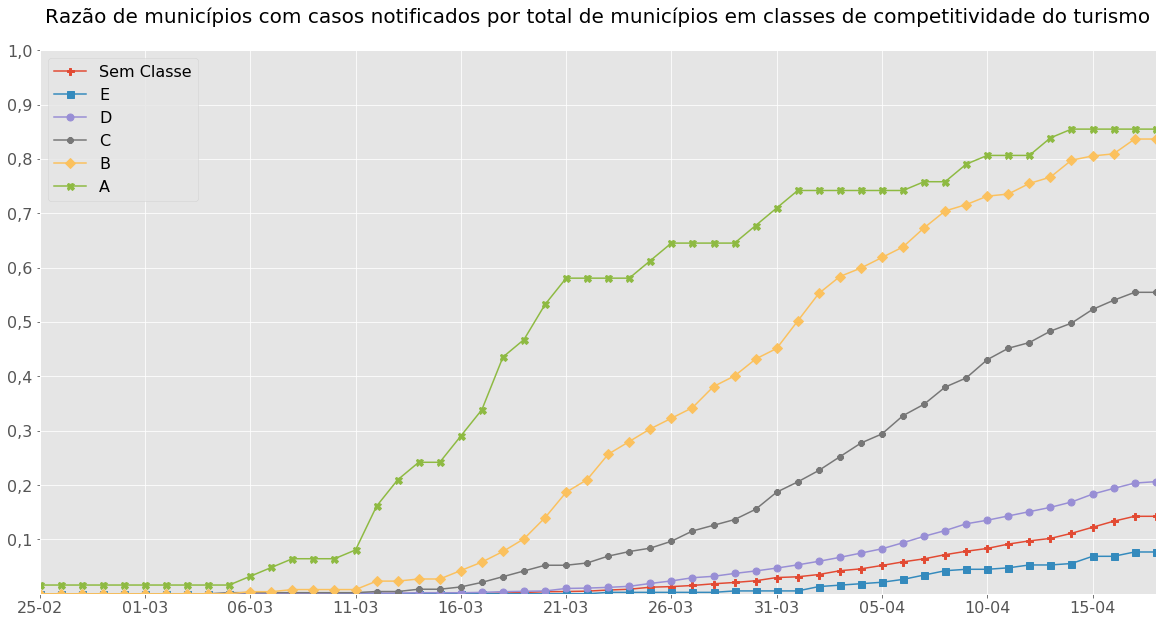

In [52]:
plot_razao_municipios_afetados(df=df_classes_turismo_fracao, titulo='Razão de municípios com casos notificados por total de municípios em classes de competitividade do turismo', save_fig=None)